# Ansatz

In [143]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Imports

In [144]:
# imports
from matplotlib import pyplot as plt
import numpy as np

import os

# import data class
from utilities.dataset_utils import DiabetesData

from qiskit_machine_learning.algorithms import VQC

from qiskit import QuantumCircuit

# explainability imports
# feature map SHAP
from shap import KernelExplainer
from shap import Explanation
from shap.plots import waterfall

# state fidelity
from qiskit.quantum_info import state_fidelity

# qiskit imports
# simulator
from qiskit_aer import AerSimulator
from qiskit_aer.primitives import SamplerV2 as Sampler

Dataset loading - change code hear to analyze different dataset

**N.B.** works only for binary classification datasets

In [145]:
# path to diabetes.csv
path = os.path.join(os.getcwd(), '..', '..', 'utilities', 'diabetes.csv')
# load dataset class
dataset = DiabetesData(path)

In [146]:
# path to diabetes.csv
path = os.path.join(os.getcwd(), '..', '..', 'models', 'qml-simulator', 'vqc_best_params.model')

vqc = VQC.load(path)

In [147]:
# list of feature names
feature_names = [
    "Pregnancies",
    "Glucose",
    "BloodPressure",
    "SkinThickness",
    "Insulin",
    "BMI",
    "DiabetesPedigreeFunction",
    "Age"
]

In [148]:
# get data
X_train, X_test, y_train, y_test = dataset.preprocess_data_ranged()

In [149]:
# setup backend simulator
backend = AerSimulator()
backend.set_options(max_parallel_threads=os.cpu_count(), method='statevector')

In [150]:
# sampler
sampler = Sampler.from_backend(backend)

### Ansatz Explainability

Ansatz implementation - change here to analyze different ansatz

In [151]:
# generate feature map to fix to a training sample
feature_map = vqc.feature_map

In [152]:
# generate ansatz used
ansatz = vqc.ansatz

In [153]:
print(ansatz.name)
print(ansatz.num_qubits)

RealAmplitudes
8


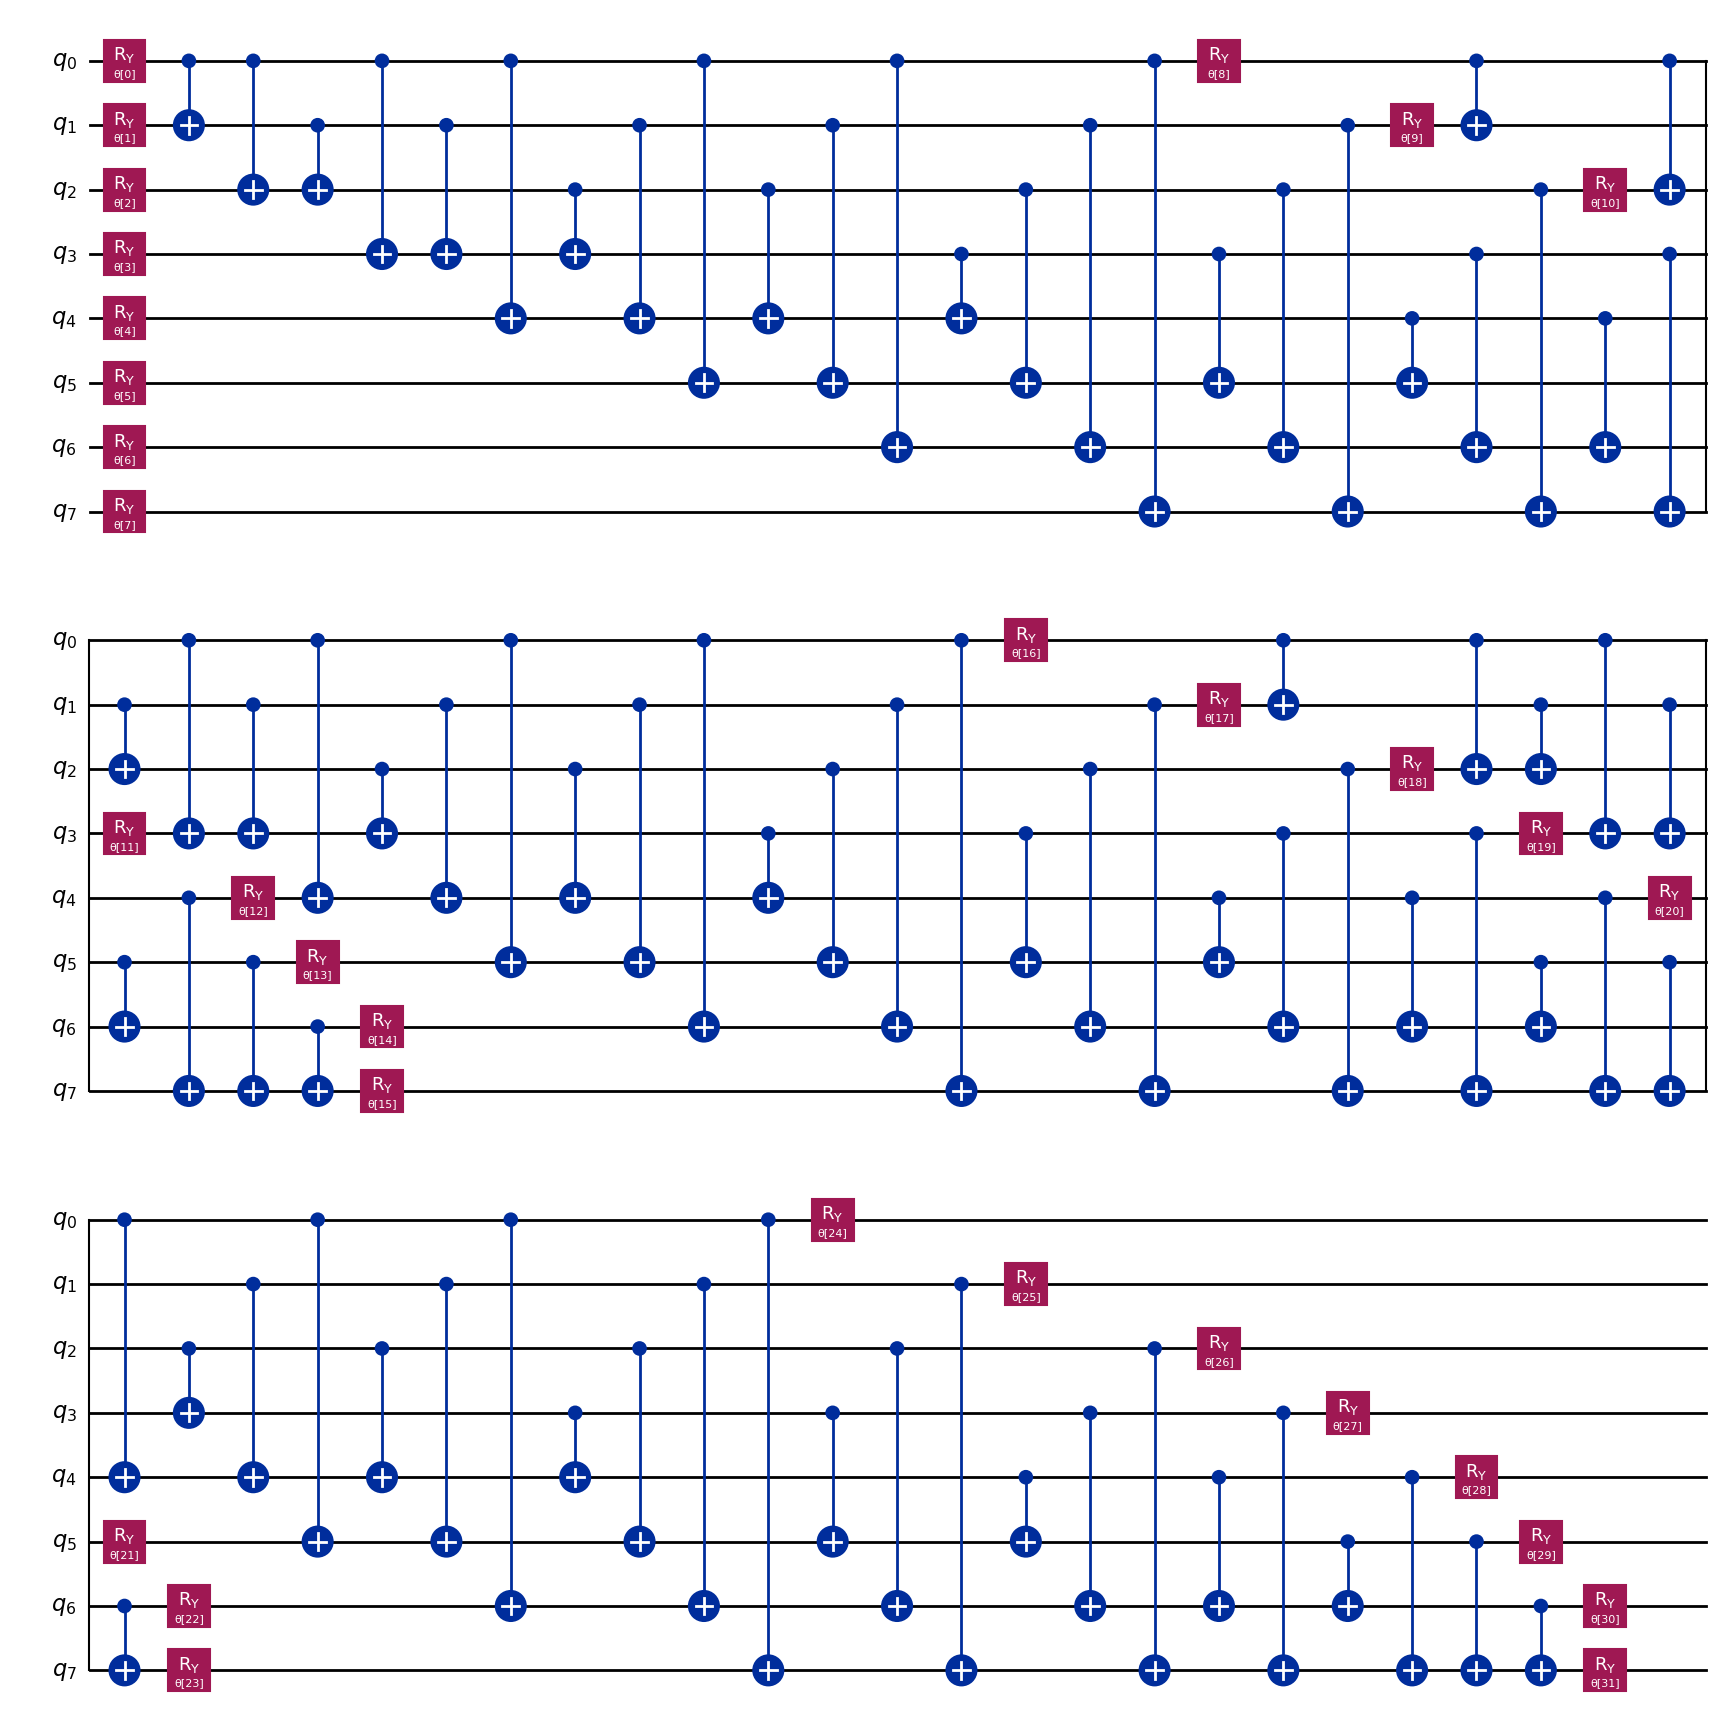

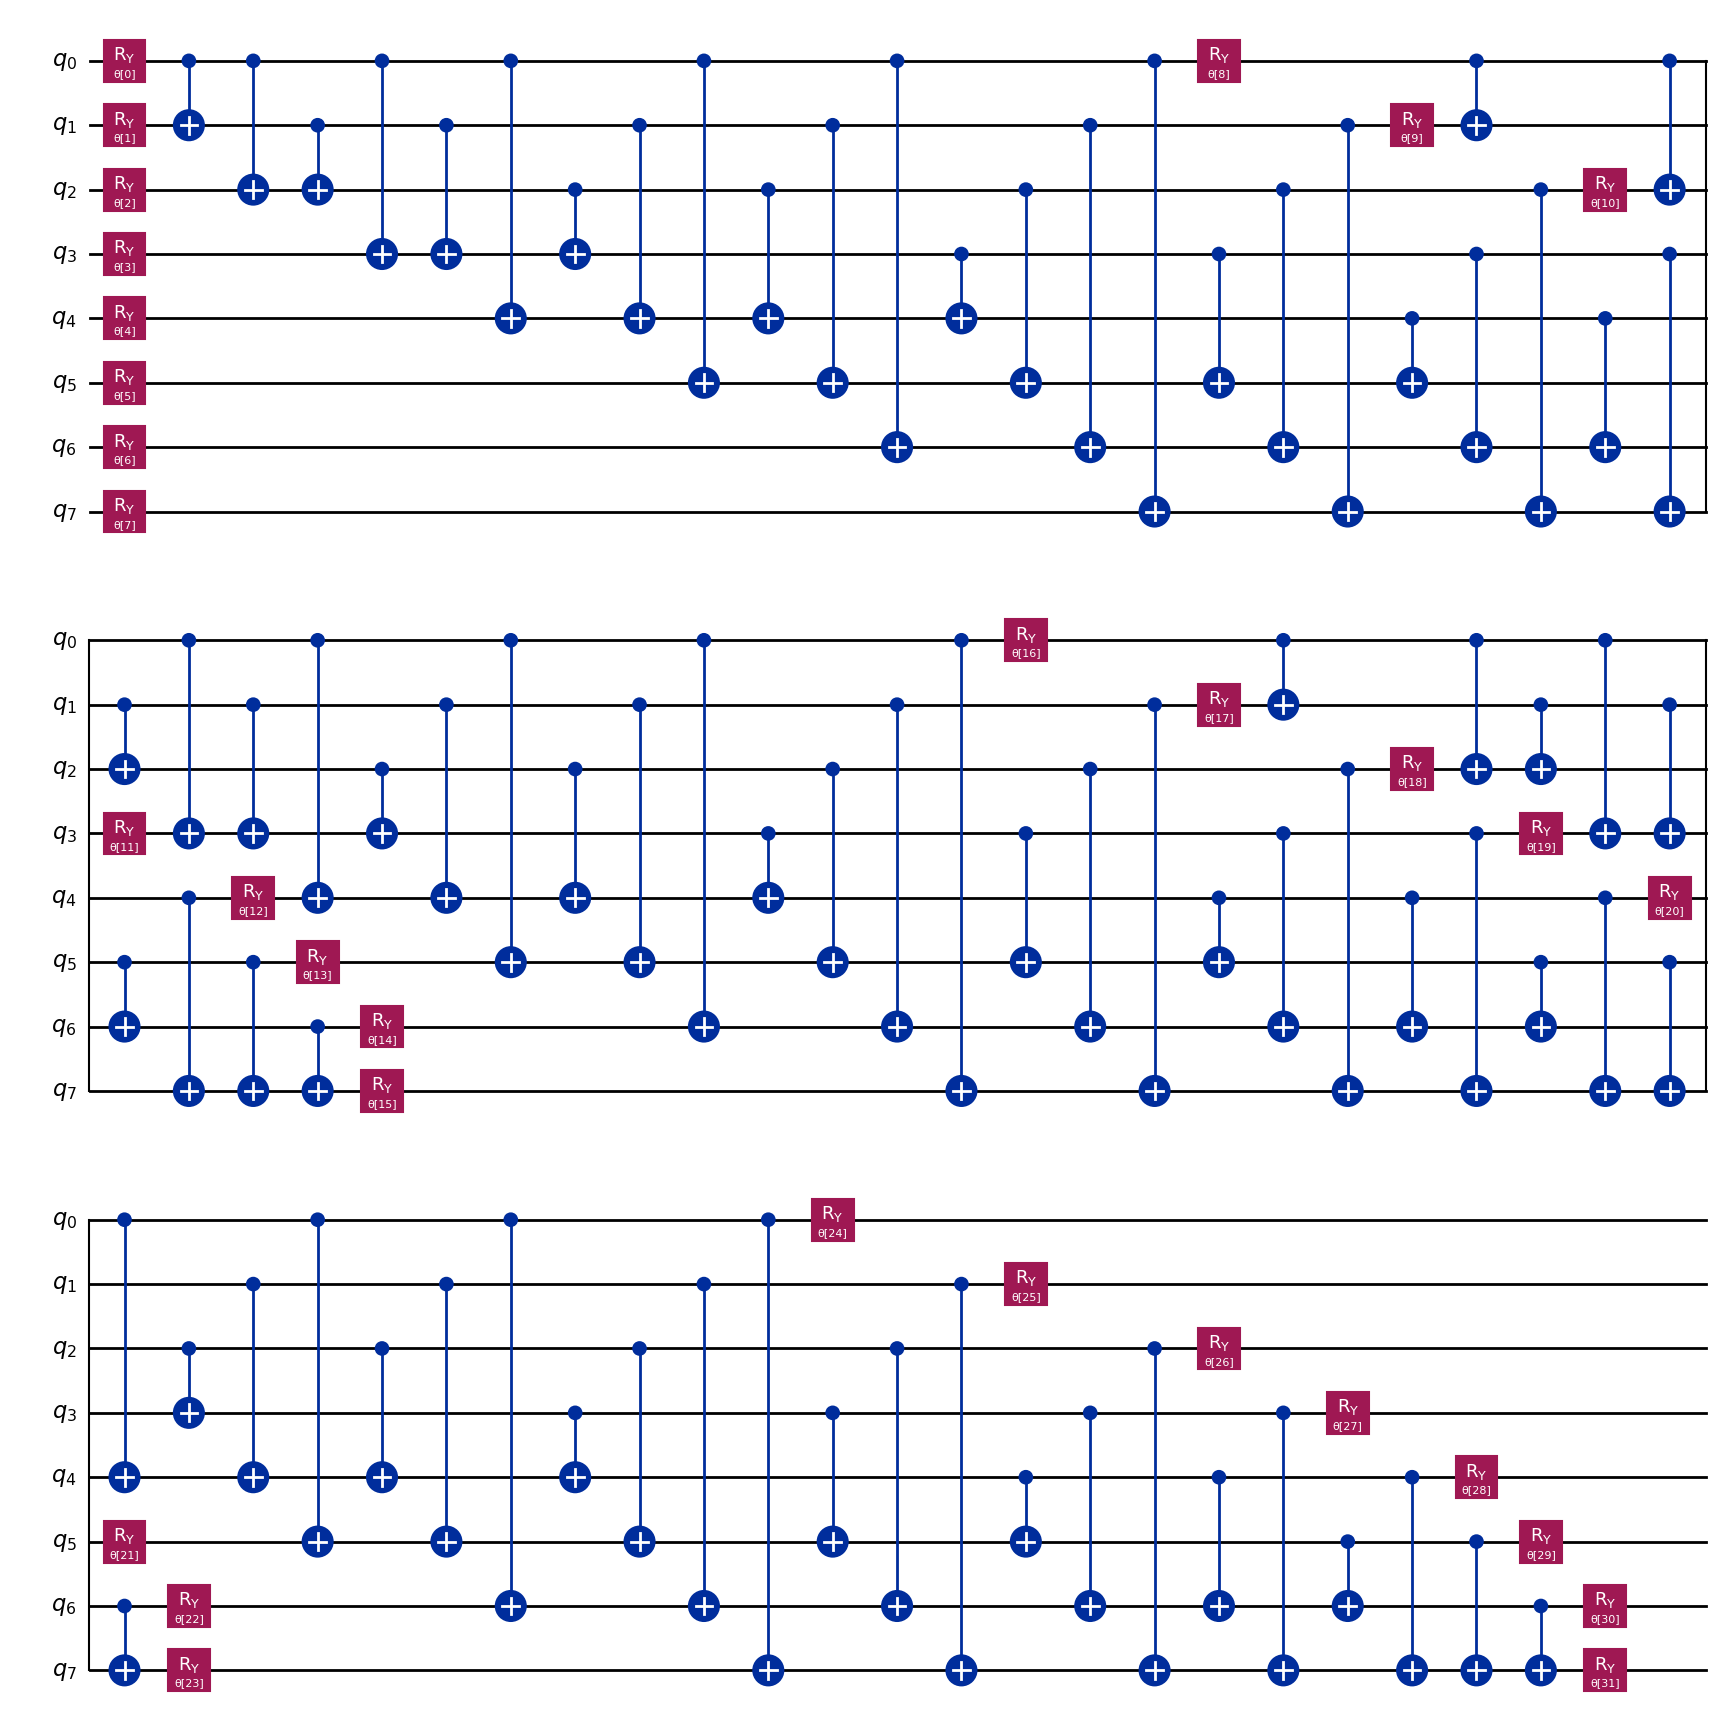

In [154]:
ansatz.draw('mpl')

In [155]:
# sample to explain
X_sample = X_train[150]

In [156]:
fm_param_dict = dict(zip(feature_map.parameters, X_sample))
fixed_fm = feature_map.assign_parameters(fm_param_dict)

In [157]:
opt_params = vqc.fit_result.x

In [158]:
bound_ansatz = ansatz.assign_parameters(dict(zip(ansatz.parameters, opt_params)))

In [159]:
ref_circuit = fixed_fm.compose(bound_ansatz, inplace=False)
ref_circuit.save_statevector()

In [160]:
def copy_circuit(qc: QuantumCircuit) -> QuantumCircuit:
    try:
        return qc.copy()
    except AttributeError:
        return QuantumCircuit.from_qasm_str(qc.qasm())

In [161]:
result = backend.run(ref_circuit).result()
ref_state = result.get_statevector()

In [162]:
# function to get quantum state
def ansatz_model_out(params):
    """
    Gets quantum state of a given data point
    """
    # # flatten params to 1D
    # params = np.array(params).flatten()
    
    # # copy ansatz
    # qc = copy_circuit(ansatz)
    
    # #create param dict and assign to circuit
    # param_dict = dict(zip(ansatz.parameters, params))
    
    # qc = qc.assign_parameters(param_dict)
    
    # # compose with fixed feature map
    # qc = fixed_fm.compose(qc)
    
    # # save statevector
    # qc.save_statevector()
    
    # # run on statevector simulator
    # result = backend.run(qc).result()
    # state = result.get_statevector()
    # fidelity = state_fidelity(state, ref_state)
    # return np.array([[fidelity]])
    # Ensure params is a NumPy array.
    params = np.array(params)
    # If the input is a single sample (1D), convert to 2D.
    if params.ndim == 1:
        params = params.reshape(1, -1)
    
    pred_list = []
    
    for row in params:
        # Create a fresh copy of the ansatz.
        new_ansatz = copy_circuit(ansatz)
        # Compose with the fixed feature map.
        composed_circuit = fixed_fm.compose(new_ansatz, inplace=False)
        
        # Get free parameters of the composed circuit.
        composed_free_params = list(composed_circuit.parameters)
        if len(composed_free_params) != len(row):
            raise ValueError(f"Expected {len(composed_free_params)} parameters, but got {len(row)}.")
        
        # Build the parameter dictionary from the composed circuit parameters.
        param_dict = dict(zip(composed_free_params, row))
        assigned_circuit = composed_circuit.assign_parameters(param_dict, inplace=False)
        assigned_circuit.save_statevector()
        
        sim_result = backend.run(assigned_circuit).result()
        state = sim_result.get_statevector()
        fidelity = state_fidelity(state, ref_state)
        
        pred_list.append([fidelity])  # Append as a list so final shape is (n,1)
    
    return np.array(pred_list)

```python
state_similarity
```
Measures the state fidelity between two quantum states. Fidelity is expressed as:
$$F=| \langle \psi | \phi \rangle |^2 $$

where $|\psi\rangle$ is the actual state and $|\phi\rangle$ is the target state. A fidelity of 1 indicates identical states while 0 indicates orthogonal states (different).

In [163]:
# # function to calculate fidelity from a datapoint
# def ansatz_similarity(x):
#     """
#     Measures similarity between two states
#     """
#     # get quantum state
#     state = get_quantum_state(x)
    
#     # calculate state fidelity
#     fidelity = np.abs(state_fidelity(state, trained_params))
#     return fidelity

In [164]:
def ansatz_parameter_shap(opt_params, background_params, ansatz_params, feature_names=None):
    """
    Calculate SHAP for ansatz parameters to explain how they contribute to the quantum state
    """
    explainer = KernelExplainer(
        model=ansatz_model_out,
        data=background_params
    )
    
    shap_values = explainer.shap_values(opt_params.reshape(1, -1))
    
    single_exp = shap_values[0]
    if single_exp.ndim > 1:
        single_exp = single_exp.flatten()
    abs_values = np.abs(single_exp)
    total = np.sum(abs_values)
    normalised_values = single_exp / total if total > 0 else single_exp
    
    plt.figure(figsize=(10, 6))
        
    explanation = Explanation(
        values=normalised_values,
        base_values=explainer.expected_value,
        data=opt_params,
        feature_names=[str(param) for param in ansatz_params]
    )
    
    print(f"Expected Value: {explainer.expected_value}")
    waterfall(explanation, max_display=32, show=False)
    
    plt.title('Parameter Importance (SHAP) for Ansatz')
    plt.tight_layout()
    plt.show()
    
    return shap_values

  0%|          | 0/1 [00:00<?, ?it/s]

Expected Value: [0.92639029]


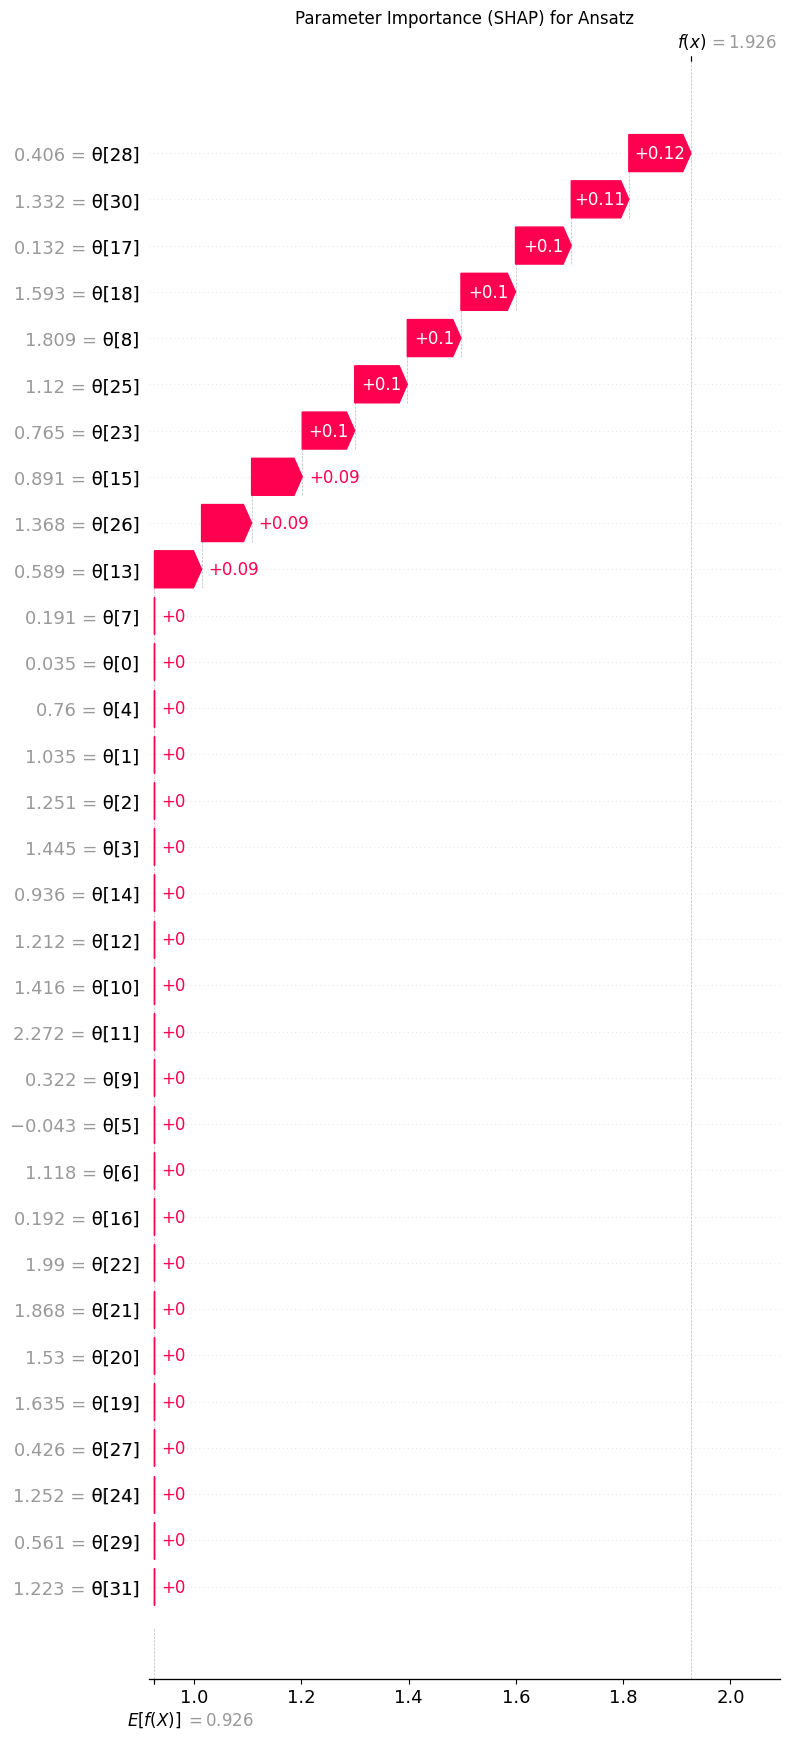

In [165]:
num_background = 100
background_params = np.array([opt_params + np.random.normal(0, 0.1, size=opt_params.shape) for _ in range(num_background)])

shap_values = ansatz_parameter_shap(
    opt_params=opt_params,
    background_params=background_params,
    ansatz_params=ansatz.parameters,
    feature_names=None
)